In [1]:
import numpy as np
import pandas as pd
import os
import time
from tqdm import tqdm, trange
import sys
import matplotlib.pyplot as plt


# variaveis
L = 100 # lado do lattice
n_lagartos = L**2 # lagartos que cabem no lattice
estrategias = ['O', 'Y', 'B'] # estratégias possíveis
index_map = {'O': 0, 'Y': 1, 'B': 2}
n_geracoes = 100
n_pop = 1 # número de populações independentes
prob_mutacao = None # probabilidade de mutação a cada geração
output_dir = "C:/Unicamp/mestrado/simulacoes/RPS-python/RPS-POO/outputs/teste/custo_Y/"
os.makedirs(output_dir, exist_ok=True)

In [2]:
class Lagarto:
  def __init__(self, i, j, estrategia, fitness, coord_vizinhos, estrategia_vizinhos, coord_vizinhanca_extendida, estrategia_vizinhanca_extendida, t, n_vizinhos, n_vizinhos_realizado):
    self.i = i # linha
    self.j = j # coluna
    self.estrategia = estrategia
    self.fitness = 0 # inicia com 0 de fitness
    self.coord_vizinhos = [] # lista vazia para adicionar as coordenadas dos vizinhos
    self.estrategia_vizinhos = [] # lista vazia para adicionar as estratégias dos vizinhos
    self.coord_vizinhanca_extendida = []
    self.estrategia_vizinhanca_extendida = []
    self.t = 0 # determina a geracao do lagarto
    self.n_vizinhos = n_vizinhos # número de vizinhos
    self.n_vizinhos_realizado = 0 # número de vizinhos realizados


  def calcular_coord_vizinhos(self, L): # obtém as coordenadas dos vizinhos

    lista_vizinhos = []
    vizinhos_possiveis = []
    n_v = self.n_vizinhos

    for dx in range(-3, 4): 
        for dy in range(-3, 4):
            if dx == 0 and dy == 0: # ignora ele mesmo
                continue
            ni = (self.i + dx) % L # fronteiras periódicas
            nj = (self.j + dy) % L # fronteiras periódicas
            vizinhos_possiveis.append(((ni, nj), max(abs(dx), abs(dy)))) # armazena a coordenada dos vizinhos possíveis e a sua distância até o lagarto atual
        # Ordena os vizinhos por distância (mais próximos primeiro)
        vizinhos_possiveis.sort(key=lambda x: x[1])
        lista_vizinhos = [coord for coord, _ in vizinhos_possiveis[:n_v]]

    self.coord_vizinhos = lista_vizinhos # armazena as coordenadas dos vizinhos na variável do lagarto
    
  def obter_estrategia_vizinhos(self, matriz_posicao):
      self.estrategia_vizinhos = [matriz_posicao[ni, nj] for ni, nj in self.coord_vizinhos] # dadas as coordenadas, obtém a estratégia do lagarto que ocupa aquela posição

  def mutacao(self, prob_mutacao): # função de mutação
    if np.random.rand() < prob_mutacao: # sorteia um valor entre 0 e 1, se for menor que a probabilidade de mutação, o lagarto muda de estratégia
        estrategias_possiveis = [e for e in estrategias if e != self.estrategia] # obtém as estratégias possíveis, exceto a atual
        self.estrategia = np.random.choice(estrategias_possiveis) # escolhe uma nova estratégia aleatoriamente para mutar

  def calcular_n_vizinhos(self): # calcula o número de vizinhos
      self.n_vizinhos_realizado = len(self.estrategia_vizinhos) + len(self.estrategia_vizinhanca_extendida)

  def calcular_custo(self, a, x):
      if self.estrategia == 'Y':
          custo = (self.n_vizinhos * a) + x
      return custo
  
  def adicionar_vizinhos_inicial(self):
      if self.estrategia == 'Y':
          n_vizinho = np.random.randint(1, 49)
          self.n_vizinhos = n_vizinho
      elif self.estrategia == 'O':
          n_vizinho = 24
          self.n_vizinhos = n_vizinho
      elif self.estrategia == 'B':
          n_vizinho = 8
          self.n_vizinhos = n_vizinho

def calcular_media_vizinhos(lagartos, estrategias):
    medias = []
    for e in estrategias:
        #viz = [lag.n_vizinhos_realizado for lag in lagartos if lag.estrategia == e]
        viz = [lag.n_vizinhos for lag in lagartos if lag.estrategia == e]
        medias.append(np.mean(viz) if len(viz) > 0 else 0)
    return medias # retorna a média de vizinhos para cada estratégia

def ajustar_vizinhos_reciprocos(lagartos): # garante que se A é vizinho de B, B também é vizinho de A, pois as interações são recíprocas
    mapa = {(l.i, l.j): l for l in lagartos} # dicionário pra acessar lagartos pela posição

    for l in lagartos:
        for (ni, nj) in l.coord_vizinhos: # vai em todos os vizinhos do lagarto atual (l)
            vizinho = mapa[(ni, nj)]
            # se o lagarto atual (l) não estiver na lista de vizinhos do vizinho, adiciona em vizinhanca_extendida
            if (l.i, l.j) not in vizinho.coord_vizinhos:
                vizinho.estrategia_vizinhanca_extendida.append(str(l.estrategia))
                vizinho.coord_vizinhanca_extendida.append((l.i, l.j))

In [3]:
def criar_lagartos(n_lagartos, L, estrategias): # define as posições e estratégias dos lagartos no t = 0
  lista_lagartos = []

  # posições iniciais aleatórias
  all_positions = [(i, j) for i in range(L) for j in range(L)] # forma todas as posições possíveis em um lattice
  unique_positions_indices = np.random.choice(len(all_positions), n_lagartos, replace=False) # determina o índice de onde vai ficar cada posição
  unique_positions = [all_positions[i] for i in unique_positions_indices] # basicamente, ele embaralhou as posições

  for g in range(n_lagartos):
    i, j = unique_positions[g] # posição na matriz
    estrategia = np.random.choice(estrategias) # sorteia a estrategia
    lista_lagartos.append(Lagarto(i, j, estrategia, 0, [], [], [], [], 0, 0, 0)) # cria o lagarto
  return lista_lagartos

def calcular_fitness(lagarto, index_map, matriz_posicao): # função para calcular o fitness do lagarto
    fitness_total = 0 # inicia no 0

    b = 2 # ganho em fitness ao vencer
    c = 1.5

    if lagarto.estrategia == 'Y':
        c_O = lagarto.calcular_custo(a = 0.03, x = 0) # custo para Y por ter vizinhos O
        c_B = lagarto.calcular_custo(a = 0.01, x = 1.5) # custo para Y por ter vizinhos B
    else:
        c_O = 0
        c_B = 1.5
    
    matriz_payoff = np.array([[1, b-c, b],
                              [b-c_O, 1, b-c_B],
                              [b-c, b, 1]])
    
    todos_vizinhos = set(lagarto.coord_vizinhos + lagarto.coord_vizinhanca_extendida) # junta todos os vizinhos (normais e estendidos) em um set para evitar que um vizinho seja contado duas vezes
    for ni, nj in todos_vizinhos:
        vizinho_estrat = matriz_posicao[ni, nj] # pega a estratégia do vizinho dadas as suas coordenadas
        if vizinho_estrat is not None:
            fitness_total += matriz_payoff[index_map[lagarto.estrategia], index_map[vizinho_estrat]] # calcula o payoff do lagarto contra o vizinho de acordo com a matriz de payoff e soma ao fitness total
    lagarto.fitness = fitness_total
    return fitness_total

calcular_freq = lambda mat: np.array([np.sum(mat == s) / (L ** 2) for s in ['O', 'Y', 'B']]) # calcula a frequência de cada estratégia no lattice na ordem O, Y, B

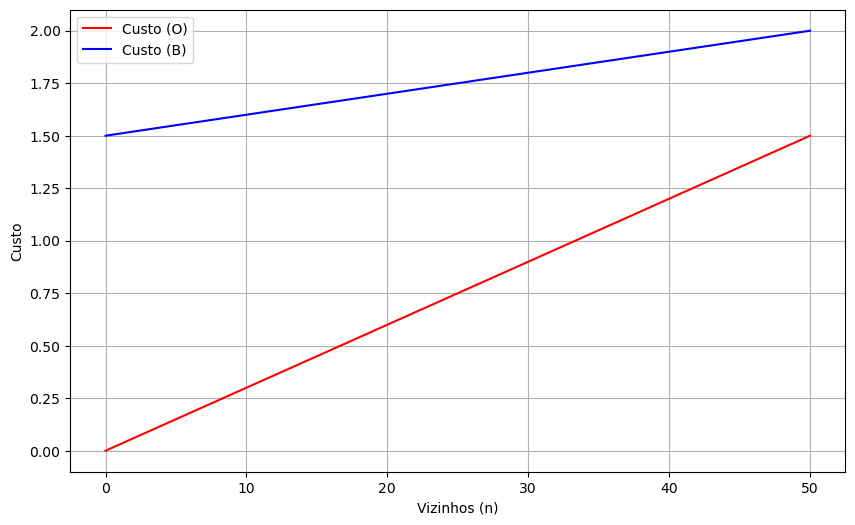

In [4]:
def funcao_investimento(vizinho, a, x):
    c = (vizinho * a) + x
    return c

plt.figure(figsize=(10, 6))
vizinho = np.linspace(0, 50, 100)

c_values = funcao_investimento(vizinho, 0.03, 0)
b_values = funcao_investimento(vizinho, 0.01, 1.5)
plt.plot(vizinho, c_values, label='Custo (O)', color='red')
plt.plot(vizinho, b_values, label='Custo (B)', color='blue')

plt.xlabel('Vizinhos (n)')
plt.ylabel('Custo')
plt.legend()
plt.grid()
plt.show()

In [5]:
def atualizar_lagartos(lagartos): # função que atualiza as estratégias dos lagartos com base no fitness dos vizinhos
    novas_estrategias = {} # Dicionário para armazenar as novas estratégias
    novas_vizinhancas = {} # Dicionário para armazenar as novas vizinhanças

    mapa = {(l.i, l.j): l for l in lagartos} # dicionário para acessar lagartos pela posição

    for lagarto in lagartos:
        melhor_estrategia = lagarto.estrategia # inicia com a própria estratégia
        maior_fitness = lagarto.fitness # verifica o fitness do próprio lagarto
        melhor_vizinhanca = lagarto.n_vizinhos

        # verifica o fitness dos vizinhos normais
        for (ni, nj) in lagarto.coord_vizinhos:
            vizinho = mapa[(ni, nj)] # usa o dicionário para achar o vizinho
            if vizinho.fitness > maior_fitness: # se o fitness do vizinho for maior que o maior fitness atual
                maior_fitness = vizinho.fitness # atualiza o maior fitness
                melhor_estrategia = vizinho.estrategia # atualiza a melhor estratégia
                melhor_vizinhanca = vizinho.n_vizinhos
                # se houver empate de fitness ou for menor, mantém a estratégia atual (não muda)

        # verifica o fitness dos vizinhos extendidos
        for (ni, nj) in lagarto.coord_vizinhanca_extendida:
            vizinho = mapa[(ni, nj)] 
            if vizinho.fitness > maior_fitness:
                maior_fitness = vizinho.fitness
                melhor_estrategia = vizinho.estrategia
                melhor_vizinhanca = vizinho.n_vizinhos

        novas_estrategias[(lagarto.i, lagarto.j)] = melhor_estrategia # armazena a nova estratégia no dicionário
        novas_vizinhancas[(lagarto.i, lagarto.j)] = melhor_vizinhanca # armazena a nova vizinhança no dicionário

    # atualiza as estratégias de todos os lagartos simultaneamente
    for lagarto in lagartos:
        lagarto.estrategia = novas_estrategias[(lagarto.i, lagarto.j)] # evita que a atualização de um lagarto influencie outro na mesma geração (sem sobreposição de geração)
        lagarto.n_vizinhos = novas_vizinhancas[(lagarto.i, lagarto.j)]
    
    return lagartos

Etapas da simulação:
1. cria os lagartos com posição e estratégia
2. adiciona o número de vizinhos de acordo com a estratégia
3. determina quem são os vizinhos de cada lagarto (coordenada e estratégia)
4. ajusta vizinhos recíprocos (pega coordenada e estratégia)
5. recalcula o número de vizinhos efetivos de acordo com a reciprocidade
6. armazena a média do número de vizinhos por estratégia
7. calcula o fitness de cada lagarto com base nos seus vizinhos e no jogo
8. atualiza os lagartos, substituindo a estratégia e o número de vizinhos daquele com maior fitness
9. permite mutação de prob_mutação não for None
10. cria uma nova matriz de posição com os lagartos atualizados
11. calcula as frequências das estratégias

Explicando cada variável dentro da função:

1. matriz_frequencias:
        Matriz 3D que armazena a frequência de cada estratégia em cada geração e população.
        Eixo 0: gerações (de 0 até n_geracoes)
        Eixo 1: populações independentes
        Eixo 2: tem tamanho 3 e vai armazenar as frequências das estratégias (O, Y, B) no formato [0.3, 0.3, 0.3]

2. matriz_n_vizinhos_media:
        Matriz 3D que armazena a média do número de vizinhos realizados para cada estratégia, geração e população.
        Mesma estrutura de índices que matriz_frequencias, mas armazena o número de vizinhos no formato [x, y, z]

3. n_vizinhos_individual:
        Lista de listas de listas:
                Para cada população:
                        Para cada geração:
                                Para cada lagarto: número de vizinhos realizados daquele lagarto.
        Exemplo: n_vizinhos_individual[pop][t][i] é o número de vizinhos do lagarto i na geração t da população pop.

4. historico_estrategias:
        Mesmo formato do n_vizinhos_individual, mas para cada lagarto, temos a estratégia daquele lagarto.
        Exemplo: historico_estrategias[pop][t][i] é a estratégia do lagarto i na geração t da população pop.

In [6]:
# iniciando a simulação
def simulacao(n_geracoes, L, n_lagartos, estrategias, index_map, n_pop, prob_mutacao = None, seed = None):
    matriz_frequencias = np.full((n_geracoes + 1, n_pop, len(estrategias)), np.nan, dtype=float) # cria uma matriz para armazenar as frequências em cada instante dos loops
    matriz_n_vizinhos_media = np.full((n_geracoes + 1, n_pop, len(estrategias)), np.nan, dtype=float) # cria uma matriz para armazenar vizinhos
    n_vizinhos_individual = []  # lista para armazenar todos os números de vizinhos
    historico_estrategias = [] # lista para armazenar o histórico de estratégias de cada população

    for pop in range(n_pop): # loop para cada população independente
      if seed is not None:
        np.random.seed(seed + pop) # coloca uma semente diferente pra cada pop, garantindo independência e reproducibilidade

      frequencias = [] # vai armazenar as frequências ao longo das gerações para essa população
      matriz_posicao = np.full((L, L), None) # cria uma matriz vazia com None
      n_vizinhos_pop = []  # [pop][t][i]
      historico_estrategias_pop = []
      
      lista_lagartos = criar_lagartos(n_lagartos, L, estrategias) # cria os lagartos
      for lagarto in lista_lagartos:
          lagarto.adicionar_vizinhos_inicial() # adiciona o número de vizinhos iniciais de acordo com a estratégia
          matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia) # cria a matriz de posições de acordo com os lagartos

      frequencias.append(calcular_freq(matriz_posicao)) # calcula a frequência inicial
      n_vizinhos_pop.append([lagarto.n_vizinhos for lagarto in lista_lagartos])  # geração inicial
      historico_estrategias_pop.append([lagarto.estrategia for lagarto in lista_lagartos])  # histórico de estratégias
      matriz_n_vizinhos_media[0, pop, :] = calcular_media_vizinhos(lista_lagartos, estrategias)

      for t in range(1, n_geracoes + 1): # loop para cada geração dentro da população
        # determinando os vizinhos
        for lagarto in lista_lagartos:
          lagarto.calcular_coord_vizinhos(L) # calcula as coordenadas dos vizinhos
          lagarto.obter_estrategia_vizinhos(matriz_posicao) # obtém as estratégias dos vizinhos
          # zera a vizinhança estendida para recalcular a cada lagarto
          lagarto.coord_vizinhanca_extendida = [] 
          lagarto.estrategia_vizinhanca_extendida = [] 

        ajustar_vizinhos_reciprocos(lista_lagartos) # ajusta as vizinhanças recíprocas

        for lagarto in lista_lagartos:
          lagarto.calcular_n_vizinhos() # calcula o número de vizinhos efetivo
        
        n_vizinhos_geracao = [lagarto.n_vizinhos_realizado for lagarto in lista_lagartos]
        n_vizinhos_pop.append(n_vizinhos_geracao)
      
        matriz_n_vizinhos_media[t, pop, :] = calcular_media_vizinhos(lista_lagartos, estrategias) # calcula a média de vizinhos para cada estratégia e armazena na matriz n_vizinhos
        #print(matriz_n_vizinhos[t, pop, :]) # debug

        # calculando o fitness
        for lagarto in lista_lagartos:
          calcular_fitness(lagarto, index_map, matriz_posicao) # calcula o fitness do lagarto de acordo com seus vizinhos e a matriz de fitness

        lista_lagartos = atualizar_lagartos(lista_lagartos) # atualiza as estratégias dos lagartos de acordo com o maior fitness dos vizinhos

        if prob_mutacao is not None:
          for lagarto in lista_lagartos:
            lagarto.mutacao(prob_mutacao) # aplica a mutação

        # atualiza a matriz de posição com as novas estratégias e com as mutações
        matriz_posicao = np.full((L, L), None)
        for lagarto in lista_lagartos:
          matriz_posicao[lagarto.i, lagarto.j] = str(lagarto.estrategia)
        #print(matriz_posicao)

        historico_estrategias_pop.append([lagarto.estrategia for lagarto in lista_lagartos])  # histórico de estratégias
        frequencias.append(calcular_freq(matriz_posicao)) # calcula a frequência dessa geração e armazena em frequencias

        for lagarto in lista_lagartos:
            lagarto.t += 1 # incrementa a geração do lagarto
        
      frequencias = np.array(frequencias)
      n_vizinhos_individual.append(n_vizinhos_pop)
      historico_estrategias.append(historico_estrategias_pop)
      for t in range(n_geracoes + 1):
        matriz_frequencias[t, pop, :] = frequencias[t]


    return matriz_frequencias, matriz_n_vizinhos_media, n_vizinhos_individual, historico_estrategias

freq, n_vizinhos, n_vizinhos_individual, historico_estrategias = simulacao(n_geracoes, L, n_lagartos, estrategias, index_map, n_pop, prob_mutacao, seed = 2)

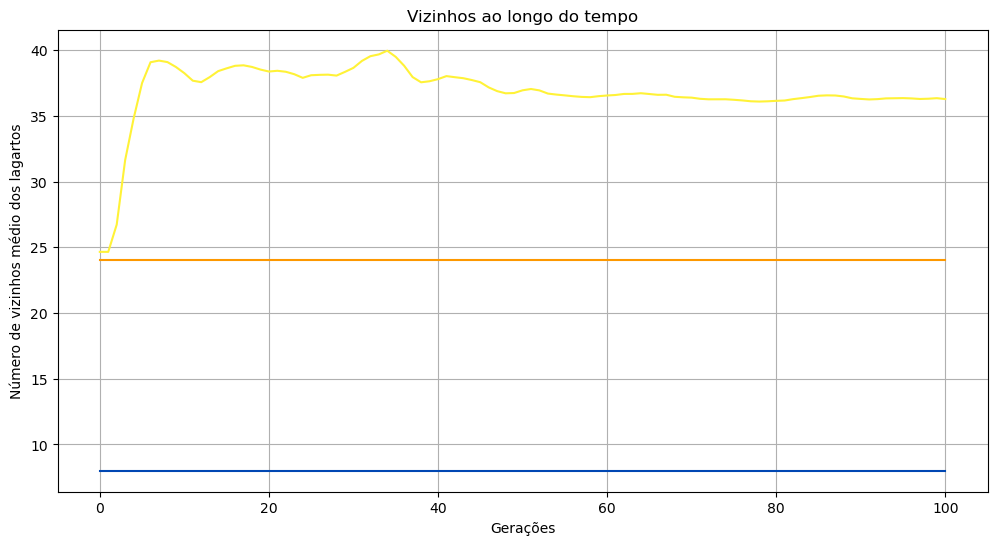

In [7]:
# salva a matriz de vizinhos como DataFrame formato tidy
linhas = []
n_vizinhos = np.array(n_vizinhos, dtype=float)  # converte para float para evitar problemas com None

for t in range(n_vizinhos.shape[0]):          # gerações
    for pop in range(n_vizinhos.shape[1]):    # populações
        for idx, strategy in enumerate(estrategias):  # estratégias
            linhas.append({
                "t": t,                        # geração
                "pop": pop,                    # população
                "estrategia": strategy,        # estratégia
                "n_vizinhos": n_vizinhos[t, pop, idx]  # média de vizinhos
            })

df_n_vizinhos = pd.DataFrame(linhas)

cores = {"O": "#FD9800", "B": "#0047B3", "Y": "#FFF237"}

plt.figure(figsize=(12, 6))

# loop por população e estratégia
for pop in df_n_vizinhos["pop"].unique():
    for strategy in estrategias:
        dados = df_n_vizinhos[(df_n_vizinhos["pop"] == pop) & (df_n_vizinhos["estrategia"] == strategy)]
        plt.plot(
            dados["t"],                # eixo x: gerações
            dados["n_vizinhos"],       # eixo y: vizinhos
            label=f"{strategy} (sim {pop+1})" if pop == 0 else None,
            color=cores[strategy],
            alpha=1
        )
plt.title("Vizinhos ao longo do tempo")
plt.xlabel("Gerações")
plt.ylabel("Número de vizinhos médio dos lagartos")
plt.grid(True)
plt.show()